# Sprawozdanie z Laboratorium 3
## Autorzy: Mateusz Pawliczek, Piotr Świerzy  
## Data: 18.03.25

## Zadanie

Celem zadania było użycie interpolacji w celu wyznaczenia przybliżonych wartości populacji w USA w latach 1990 - 1980.
Zadanie obejmuje również zbadanie jakości przybliżenia poprzez sprawdzenie wartości z poza zakresu danych oraz wpływ zaokrągleń danych na aproxymowane wyniki.

Aby wykonać to zadanie skorzystaliśmy z następującej bazy danych:

| Rok  | Populacja      |
|------|--------------:|
| 1900 |  76,212,168  |
| 1910 |  92,228,496  |
| 1920 | 106,021,537  |
| 1930 | 123,202,624  |
| 1940 | 132,164,569  |
| 1950 | 151,325,798  |
| 1960 | 179,323,175  |
| 1970 | 203,302,031  |
| 1980 | 226,542,199  |

### A , B - Utworzenie macierzy 

Opracowany program realizujący zadanie korzysta z następujących bibliotek:



In [76]:
import numpy as np
import math
import matplotlib.pyplot as plt

W celu stworzenia macierzy Vandermonde’a wybrano cztery wzory. Zostały one zaimplementowane jako wartość zwracana przez funkcję ``equation`` gdzie n określa obecnie używaną funkcję.

In [77]:
def equation(t, j, n):
    match n:
        case 0:
            return t**(j-1)
        case 1:
            return (t - 1900)**(j-1)
        case 2:
            return (t-1940)**(j-1)
        case 3:
            return ((t-1940)/40)**(j-1)
    return 1

Funkcja ``create_matrix`` tworzy macierz Vandermonde’a korzystając z wybranej funkcji dla każdego z punktów X

In [78]:
def create_matrix(X, n):
    matrix = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            matrix[i, j] = equation(X[i], j+1, n)
    return matrix

Z czterech stworzonych macierzy została wybrana tylko jedna, miała ona najniższy współczynnik uwarunkowania, który określa podatność na błędy numeryczne. Niższe współczynniki wykazują stosunkowo mała podatność na błędy.

In [79]:
x = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980]
y = [76212168, 92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203302031, 226542199]

best_cond = math.inf
best_n = 0
for n in range(4):
    A = create_matrix(x, n)
    cond_number = np.linalg.cond(A)
    if cond_number < best_cond:
        best_cond = cond_number
        best_matrix = A
        best_n = n
    print("Q" + str(n), "-", cond_number)

a = np.linalg.solve(best_matrix, y)

Q0 - 1.718562550900496e+38
Q1 - 6306565084492795.0
Q2 - 9315536054612.764
Q3 - 1605.4437004786996


Macierzą o najmniejszym współczynniku okazała się ta która używała funkcji Q3 - ``((t-1940)/40)**(j-1)``, która poza normalizacją danych względem roku 1940 dodatkowo skalowała je dzieląc ich wartość przez 40 w celu uzyskania mniejszych liczb, które łatwiej jest podnieść do wyższych potęg.

### C - Rysowanie wykresu z wartościami Interpolowanymi

W celu narysowania wykresu stworzona została funkcja ``interpolate`` wykorzystującą schemat Hornera do zwrócenia przybliżonej wartości argumentu x. Funkcja obejmuje wartości z poza dziedziny.

In [80]:
def interpolate(t, coeff, degree=0):
    if degree == len(coeff) - 2:
        return coeff[degree] + coeff[degree+1] * ((t-1940)/40)
    return coeff[degree] + ((t-1940)/40) * interpolate(t, coeff, degree+1)

Rysowanie zostało zrealizowane za pomocą poniższego kodu:

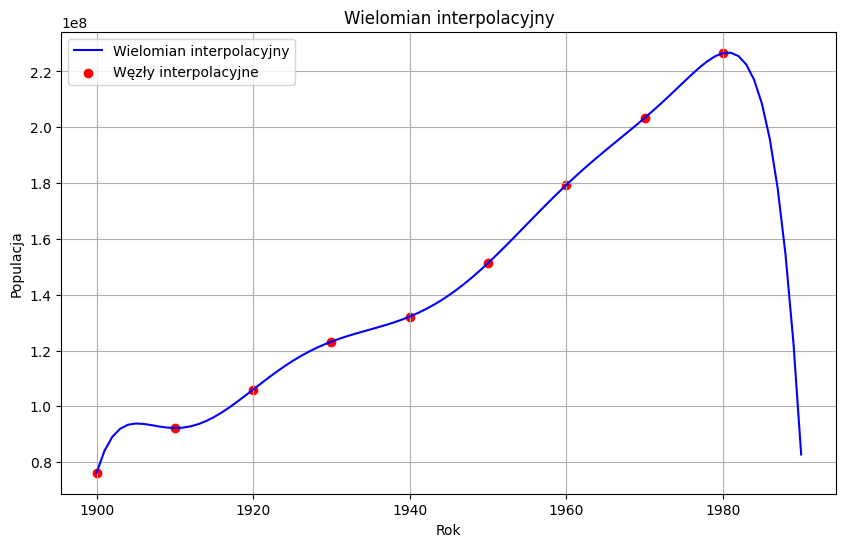

In [81]:
x_vals = np.arange(1900, 1991, 1)
y_vals = [interpolate(t , a) for t in x_vals]

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Wielomian interpolacyjny", color='b')
plt.scatter(x, y, color='r', label="Węzły interpolacyjne")
plt.xlabel("Rok")
plt.ylabel("Populacja")
plt.title("Wielomian interpolacyjny")
plt.legend()
plt.grid()
plt.show()

### D - Ekstrapolacja wartości dla 1990 roku

W ramach sprawdzenia jakości przybliżeń w latach nie obejmujących zakresu 1990 - 1980 sprawdzono wartość funkcji ``interpolate`` dla t = 1990, wynik porównano z faktyczną wartością populacji w USA w 1990, która wynosiła 248709873.

In [82]:
year_1990_true = 248709873
year_predicted = interpolate(1990 , a)
print("Prawdziwa wartość dla 1990 roku: " , year_1990_true)
print("Przewidziana wartość dla 1990 roku: ", year_predicted)
relative_population_error = (abs(year_1990_true - year_predicted) / year_1990_true) * 100
print("Błąd względny ekstrapolacji dla roku 1990:", relative_population_error)


Prawdziwa wartość dla 1990 roku:  248709873
Przewidziana wartość dla 1990 roku:  82749141.00000246
Błąd względny ekstrapolacji dla roku 1990: 66.72864651416454


Z otrzymanych wyników można wywnioskować, że metoda interpolacji nie umożliwiła przybliżenia wyników wychodzących poza przewidziany przez dane wejściowe zakres. Różnica między przybliżoną wartością populacji, a faktyczną jest bardzo duża **165 960 732**. Błąd względny ekstrapolacji wyniósł ponad **66%**. Jest to duża wartość i sugeruje małą dokłądność tej metody. 

### E - Interpolacja metodą Lagrange'a

Ta część zadania ma na celu wyznaczenie corocznych wartości za pomocą wielomianu interpolacyjnego Lagrange'a. W tym celu zostały stworzone funkcje ``lagrange_basis`` oraz ``lagrange_interpolation``.

In [83]:
def lagrange_basis(x, i, t):
    result = 1.0
    for j in range(len(x)):
        if j != i:
            result *= (t - x[j]) / (x[i] - x[j])
    return result

def lagrange_interpolation(x, y, t):
    result = 0.0
    for i in range(len(x)):
        result += y[i] * lagrange_basis(x, i, t)
    return result

Obliczone wartości zostały nałożone na wykres:

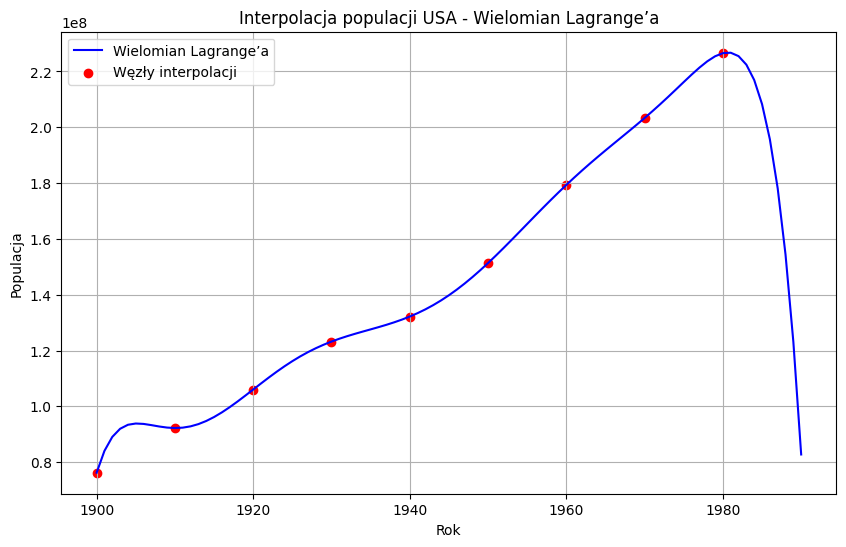

In [84]:
y_vals = np.array([lagrange_interpolation(x,y,t) for t in x_vals])

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label='Wielomian Lagrange’a', color='blue')
plt.scatter(x, y, color='red', label='Węzły interpolacji')
plt.xlabel('Rok')
plt.ylabel('Populacja')
plt.title('Interpolacja populacji USA - Wielomian Lagrange’a')
plt.legend()
plt.grid()
plt.show()

### F - Interpolacja metodą Newtona

Ta część zadania ma na celu wyznaczenie corocznych wartości za pomocą wielomianu interpolacyjnego Newtona. W tym celu zostały stworzone funkcje ``divided_differences`` oraz ``newton_interpolation``.

In [85]:
def divided_differences(x, y):
    n = len(x)
    coef = np.array(y, dtype=float)
    for j in range(1, n):
        for i in range(n-1, j-1, -1):
            coef[i] = (coef[i] - coef[i-1]) / (x[i] - x[i-j])
    return coef

def newton_interpolation(x, coef, t):
    n = len(coef)
    result = coef[-1]
    for i in range(n-2, -1, -1):
        result = result * (t - x[i]) + coef[i]
    return result

Obliczone wartości zostały nałożone na wykres:

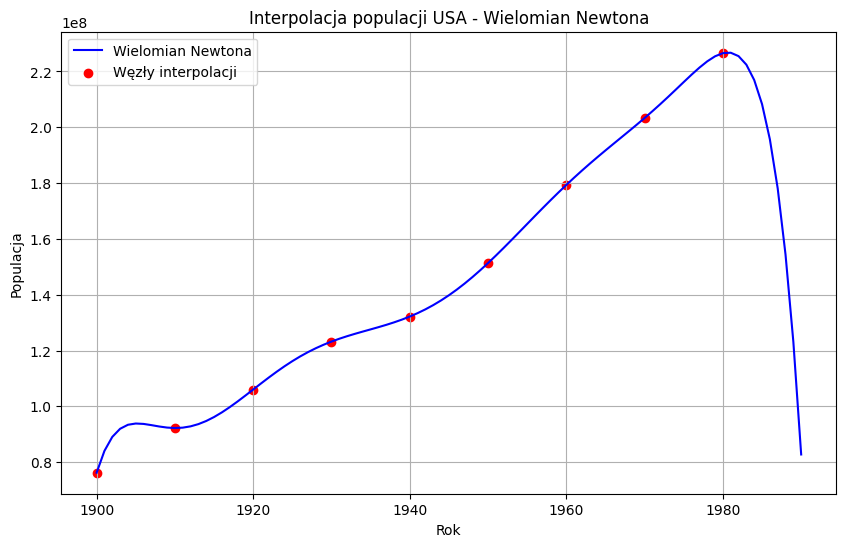

In [86]:
coef = divided_differences(x, y)

y_vals = np.array([newton_interpolation(x, coef, t) for t in x_vals])

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label='Wielomian Newtona', color='blue')
plt.scatter(x, y, color='red', label='Węzły interpolacji')
plt.xlabel('Rok')
plt.ylabel('Populacja')
plt.title('Interpolacja populacji USA - Wielomian Newtona')
plt.legend()
plt.grid()
plt.show()

### G - Interpolacja Populacji dla wartości Zaokrąglonych

W ramach tego zadania zostaną ponownie wykonane czynności wymagane do interpolacji danych populacji lat 1900 - 1980. Schemat wykonania zadanie nie zmieni się, natomiast dane wejściowe zostaną zaokrąglone do wartości milionowych.
Poniżej znajduje się realizacja tego zadania nałożona na wykres:

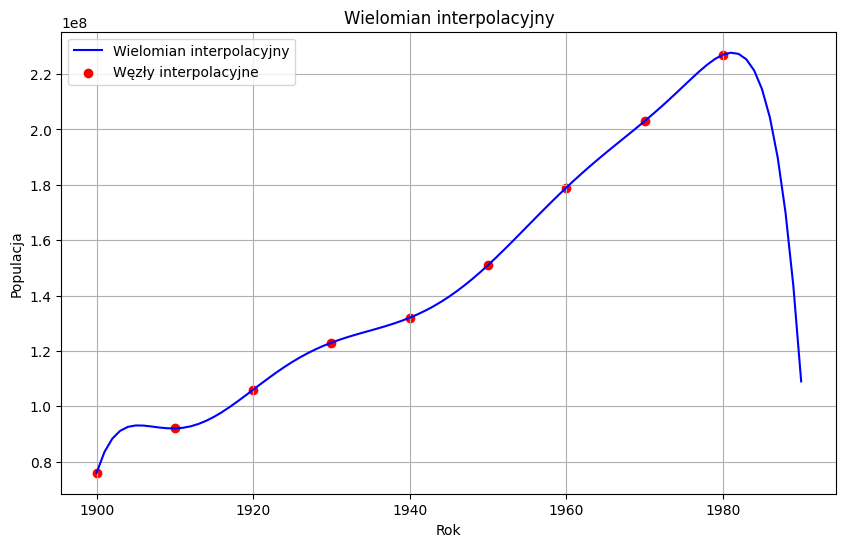

In [87]:
x = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980]
y = [76000000, 92000000, 106000000, 123000000, 132000000, 151000000, 179000000, 203000000, 227000000]


A_rounded = create_matrix(x, best_n)

a_rounded = np.linalg.solve(best_matrix, y)

y_vals = [interpolate(t , a_rounded) for t in x_vals]

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Wielomian interpolacyjny", color='b')
plt.scatter(x, y, color='r', label="Węzły interpolacyjne")
plt.xlabel("Rok")
plt.ylabel("Populacja")
plt.title("Wielomian interpolacyjny")
plt.legend()
plt.grid()
plt.show()

Porównane zostały również współczynniki przed zaokrągleniem i po:

In [88]:
print("Współczynniki przed zaokrągleniem")
print(a)
print("Współczynniki po zaokrągleniu")
print(a_rounded)

Współczynniki przed zaokrągleniem
[ 1.32164569e+08  4.61307656e+07  1.02716315e+08  1.82527130e+08
 -3.74614715e+08 -3.42668456e+08  6.06291250e+08  1.89175576e+08
 -3.15180235e+08]
Współczynniki po zaokrągleniu
[ 1.32000000e+08  4.59571429e+07  1.00141270e+08  1.81111111e+08
 -3.56755556e+08 -3.38488889e+08  5.70311111e+08  1.86920635e+08
 -2.94196825e+08]


Korzystając z otrzymanego wielomianu interpolacyjnego wyznaczono wartość przybliżoną na rok 1990. Z uzyskanych danych wyznaczono błąd bezwzględny.

In [89]:
year_predicted_rounded = interpolate(1990 , a_rounded)
print("Prawdziwa wartość dla 1990 roku: " , year_1990_true)
print("Przewidziana wartość dla 1990 roku: ", year_predicted_rounded)
relative_population_error_rounded = (abs(year_1990_true - year_predicted_rounded) / year_1990_true) * 100
print("Błąd względny ekstrapolacji dla roku 1990:", relative_population_error_rounded)

Prawdziwa wartość dla 1990 roku:  248709873
Przewidziana wartość dla 1990 roku:  109000000.00000283
Błąd względny ekstrapolacji dla roku 1990: 56.17383472348006


Przybliżona wartość dla roku 1990 **109000000** jest większa niż wartość przybliżona dla wielomianu interpolacyjnego stworzonego z danych bez zaokrągleń **82749141**. Błąd względny jest mniejszy z czego wynika, że zaokrąglenie poprawiło przewidywania, ale i tak jest to błąd około 50%, co jest wynikiem bardzo złym.

## WNIOSEK

Interpolacja to świetne narzędzie pozwalające na przybliżenie wartości wychodzących poza znane nam argumenty. Metoda ta nie powinna być jednak używana do przewidywania wyników zdarzeń przyszłych. Najlepsze zastosowanie znajduje w uzupełnianiu danych z przeszłości.